In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
MSFT_m['ticker'] = 'MSFT'
MSFT_ob['ticker'] = 'MSFT'

AMZN_m = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)
AMZN_ob = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AMZN_m['ticker'] = 'AMZN'
AMZN_ob['ticker'] = 'AMZN'

AAPL_m = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_message_10.csv", header=None)
AAPL_ob = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AAPL_m['ticker'] = 'AAPL'
AAPL_ob['ticker'] = 'AAPL'

INTC_m = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_message_10.csv", header=None)
INTC_ob = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
INTC_m['ticker'] = 'INTC'
INTC_ob['ticker'] = 'INTC'

GOOG_m = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_message_10.csv", header=None)
GOOG_ob = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
GOOG_m['ticker'] = 'GOOG'
GOOG_ob['ticker'] = 'GOOG'


df_m = pd.concat([MSFT_m, AMZN_m, AAPL_m, INTC_m, GOOG_m])
df_ob = pd.concat([MSFT_ob, AMZN_ob, AAPL_ob, INTC_ob, GOOG_ob])



In [4]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction', 'ticker']

df_m.columns = M_header


OB_header = []
for i in range(1, df_ob.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

OB_header.append('ticker')

df_ob.columns = OB_header

In [5]:
df_m['time'] = pd.to_timedelta(df_m['time'], unit='s')

# Define the base date
base_date = pd.Timestamp('2012-06-21')

# Add the timedelta (time_sec) to the base date
df_m['datetime'] = base_date + df_m['time']

df_m.drop(columns=['time'], inplace=True)


In [6]:
df_m

,event_type,order_ID,size,price,direction,ticker,datetime
0,3,16085616,100,310400,-1,MSFT,2012-06-21 09:30:00.013994120
1,1,16116348,100,310500,-1,MSFT,2012-06-21 09:30:00.013994120
2,1,16116658,100,310400,-1,MSFT,2012-06-21 09:30:00.015247805
3,1,16116704,100,310500,-1,MSFT,2012-06-21 09:30:00.015442111
4,1,16116752,100,310600,-1,MSFT,2012-06-21 09:30:00.015789148
...,...,...,...,...,...,...,...
147911,1,287157290,300,5655600,-1,GOOG,2012-06-21 15:59:59.544131783
147912,1,287157291,200,5655600,-1,GOOG,2012-06-21 15:59:59.544132627
147913,1,287157292,300,5655600,-1,GOOG,2012-06-21 15:59:59.544133264
147914,3,287027555,100,5649700,1,GOOG,2012-06-21 15:59:59.582154048


In [7]:
# Creating event number
df_m['event_number'] = df_m.groupby(['datetime', 'ticker']).cumcount()
df_m['event_number_at_t'] = df_m.groupby(['datetime', 'ticker'])['event_type'].transform('count')

# Setting the composite index
df_m.set_index(['datetime', 'ticker', 'event_number'], inplace=True)

In [8]:
df_ob.index = df_m.index

In [9]:
df_ob['ask_price_1_prev'] = df_ob['ask_price_1'].shift()
df_ob['ask_size_1_prev'] = df_ob['ask_size_1'].shift()
df_ob['bid_price_1_prev'] = df_ob['bid_price_1'].shift()
df_ob['bid_size_1_prev'] = df_ob['bid_size_1'].shift()

In [10]:
# Define the start and end times
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:45:00").time()

# Extract the 'datetime' level from the MultiIndex and filter based on the time
filtered_index = df_m.index.get_level_values('datetime').to_series().between_time(start_time, end_time).index

# Use the filtered index to get the filtered DataFrame
df_m_mh = df_m.loc[filtered_index]
df_ob_mh = df_ob.loc[filtered_index]

In [11]:
df_m_mh = df_m_mh[~df_m_mh.index.duplicated(keep='first')]
df_ob_mh = df_ob_mh[~df_ob_mh.index.duplicated(keep='first')]

Create features for ML prediction of direction

In [12]:
df_m_mh['midprice'] = (df_ob_mh['ask_price_1'] + df_ob_mh['bid_price_1']) / 2

In [13]:
df_m_mh['ofi'] = (df_ob_mh['bid_size_1'] - df_ob_mh['ask_size_1']) / (df_ob_mh['bid_size_1'] + df_ob_mh['ask_size_1'])

We try to run ML models to predict the direction of hidden liquidity execution - these features mainly only make sense for event type 5

In [14]:
df_m_mh['prev_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t1'] = df_m_mh['prev_dir_t1'].shift(1).ffill()
df_m_mh['prev_dir_t1'].fillna(0, inplace=True)

In [15]:
df_m_mh['next_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t1'] = df_m_mh['next_dir_t1'].shift(-1).bfill()
df_m_mh['next_dir_t1'].fillna(0, inplace=True)

In [16]:
df_m_mh['prev_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t4'] = df_m_mh['prev_dir_t4'].shift(1).ffill()
df_m_mh['prev_dir_t4'].fillna(0, inplace=True)

In [17]:
df_m_mh['next_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t4'] = df_m_mh['next_dir_t4'].shift(-1).bfill()
df_m_mh['next_dir_t4'].fillna(0, inplace=True)

In [18]:
df_m_mh['next_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t3'] = df_m_mh['next_dir_t3'].shift(-1).bfill()
df_m_mh['next_dir_t3'].fillna(0, inplace=True)

In [19]:
df_m_mh['prev_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t3'] = df_m_mh['prev_dir_t3'].shift(1).ffill()
df_m_mh['prev_dir_t3'].fillna(0, inplace=True)

In [20]:
df_ob_mh

ask_price_1  ask_size_1  \
datetime                      ticker event_number                            
2012-06-21 09:30:00.013994120 MSFT   0                  309900        3788   
                                     1                  309900        3788   
2012-06-21 09:30:00.015247805 MSFT   0                  309900        3788   
2012-06-21 09:30:00.015442111 MSFT   0                  309900        3788   
2012-06-21 09:30:00.015789148 MSFT   0                  309900        3788   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 GOOG   0                 5653400           2   
2012-06-21 15:44:59.202205321 GOOG   0                 5653400           2   
2012-06-21 15:44:59.274086543 GOOG   0                 5653400           2   
2012-06-21 15:44:59.274471626 GOOG   0                 5653400          10   
2012-06-21 15:44:59.921326426 GOOG   0                 5653400          10   

                                                   bid_price_1  bid_size_1  \
datetime                      ticker event_number                            
2012-06-21 09:30:00.013994120 MSFT   0                  309500         300   
                                     1                  309500         300   
2012-06-21 09:30:00.015247805 MSFT   0                  309500         300   
2012-06-21 09:30:00.015442111 MSFT   0                  309500         300   
2012-06-21 09:30:00.015789148 MSFT   0                  309500         300   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 GOOG   0                 5650000         202   
2012-06-21 15:44:59.202205321 GOOG   0                 5650000         202   
2012-06-21 15:44:59.274086543 GOOG   0                 5650000         202   
2012-06-21 15:44:59.274471626 GOOG   0                 5650000         202   
2012-06-21 15:44:59.921326426 GOOG   0                 5650000         202   

                                                   ask_price_2  ask_size_2  \
datetime                      ticker event_number                            
2012-06-21 09:30:00.013994120 MSFT   0                  310500         100   
                                     1                  310500         200   
2012-06-21 09:30:00.015247805 MSFT   0                  310400         100   
2012-06-21 09:30:00.015442111 MSFT   0                  310400         100   
2012-06-21 09:30:00.015789148 MSFT   0                  310400         100   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 GOOG   0                 5654200         100   
2012-06-21 15:44:59.202205321 GOOG   0                 5654200         100   
2012-06-21 15:44:59.274086543 GOOG   0                 5654200         100   
2012-06-21 15:44:59.274471626 GOOG   0                 5654200         100   
2012-06-21 15:44:59.921326426 GOOG   0                 5653600          16   

                                                   bid_price_2  bid_size_2  \
datetime                      ticker event_number                            
2012-06-21 09:30:00.013994120 MSFT   0                  309300        3986   
                                     1                  309300        3986   
2012-06-21 09:30:00.015247805 MSFT   0                  309300        3986   
2012-06-21 09:30:00.015442111 MSFT   0                  309300        3986   
2012-06-21 09:30:00.015789148 MSFT   0                  309300        3986   
...                                                        ...         ...   
2012-06-21 15:44:59.138324015 GOOG   0                 5648200         100   
2012-06-21 15:44:59.202205321 GOOG   0                 5648200         100   
2012-06-21 15:44:59.274086543 GOOG   0                 5648200         100   
2012-06-21 15:44:59.274471626 GOOG   0                 5648200         100   
2012-06-21 15:44:59.921326426 GOOG   0                 5648200        

Get overall sentiment at the current time point. We look at past 5 trades.
- pos if buy interest
- neg if sell interest

In [21]:
conditions = [
    (df_m_mh['event_type'] == 1),
    (df_m_mh['event_type'] == 3),
    (df_m_mh['event_type'] == 4)
]

# Define corresponding values
values = [
    df_m_mh['direction'],
    -df_m_mh['direction'],
    df_m_mh['direction']
]

# Apply np.select
df_m_mh['sentiment'] = np.select(conditions, values, default=0)

In [22]:
df_m_mh['agg_sentiment_prev'] = df_m_mh['sentiment'].rolling(window=5).sum()
df_m_mh['agg_sentiment_prev'] = df_m_mh['agg_sentiment_prev'].fillna(0)

df_m_mh['agg_sentiment_aft'] = df_m_mh['sentiment'].iloc[::-1].rolling(window=5).sum().iloc[::-1]
df_m_mh['agg_sentiment_aft'] = df_m_mh['agg_sentiment_aft'].iloc[::-1].fillna(0)



In [23]:
df_m_mh['agg_ratio'] = (df_m_mh['price'] - df_ob_mh['bid_price_1']) / (df_ob_mh['ask_price_1'] - df_ob_mh['bid_price_1'])

In [24]:
df_m_mh['hid_at_bid'] = (df_m_mh['price'] == df_ob_mh['bid_price_1']).astype(int) 
df_m_mh['hid_at_ask'] = (df_m_mh['price'] == df_ob_mh['ask_price_1']).astype(int)

We now specify the features we will use for prediction.

In [25]:
features_hid = df_m_mh[df_m_mh['event_type']==5]

We now drop features that are not relevant

In [26]:
features_hid.drop(columns=['event_type', 'order_ID', 'price', 'direction', 'midprice', 'sentiment'], inplace=True)

In [27]:
output_hid = df_m_mh[df_m_mh['event_type']==5]['direction']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features_hid, output_hid, test_size=0.25, random_state=42)

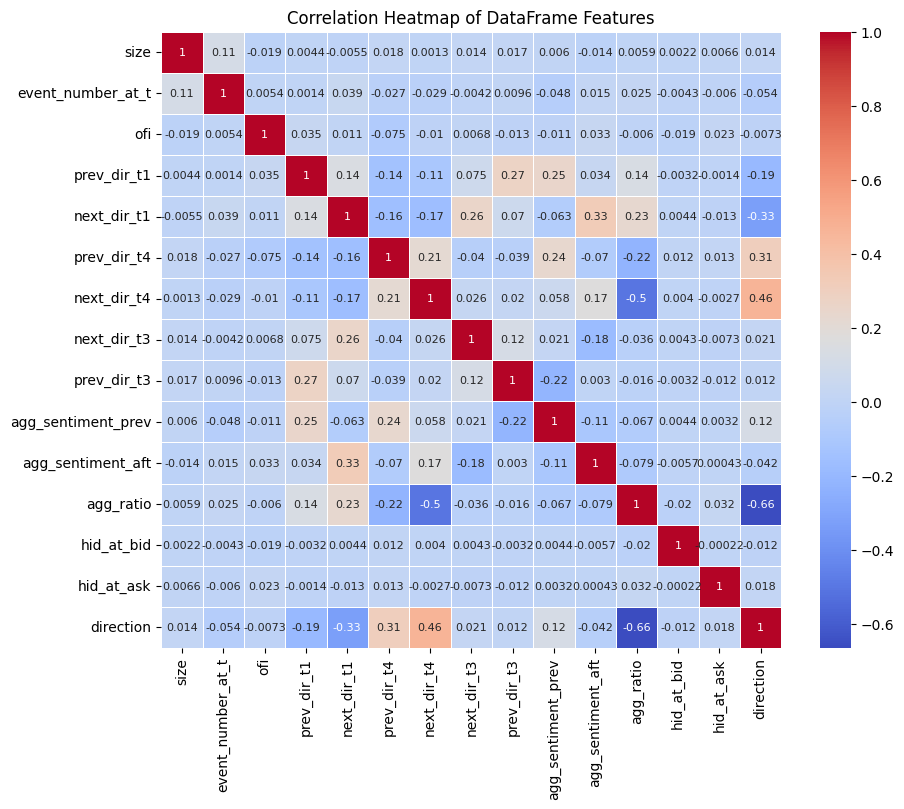

In [29]:
correlation_matrix = features_hid.merge(output_hid, left_index=True, right_index=True).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of DataFrame Features')
plt.show()

## Random Forest Classifier

In [30]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [31]:
sum(y_pred == list(y_test))/len(y_pred)

np.float64(0.8581573896353167)

In [32]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

In [33]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.88      0.87      2542
           1       0.88      0.87      0.88      2668

    accuracy                           0.87      5210
   macro avg       0.87      0.87      0.87      5210
weighted avg       0.87      0.87      0.87      5210



(array([2542.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2668.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

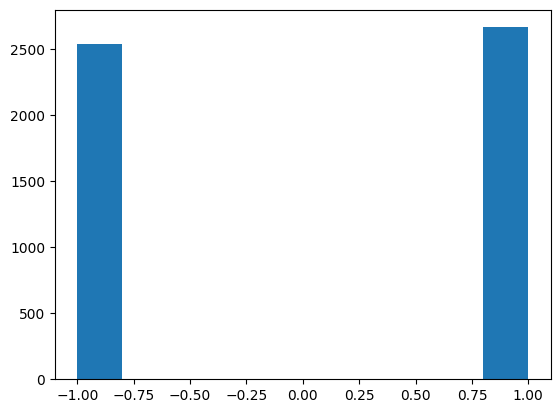

In [34]:
plt.hist(y_test)

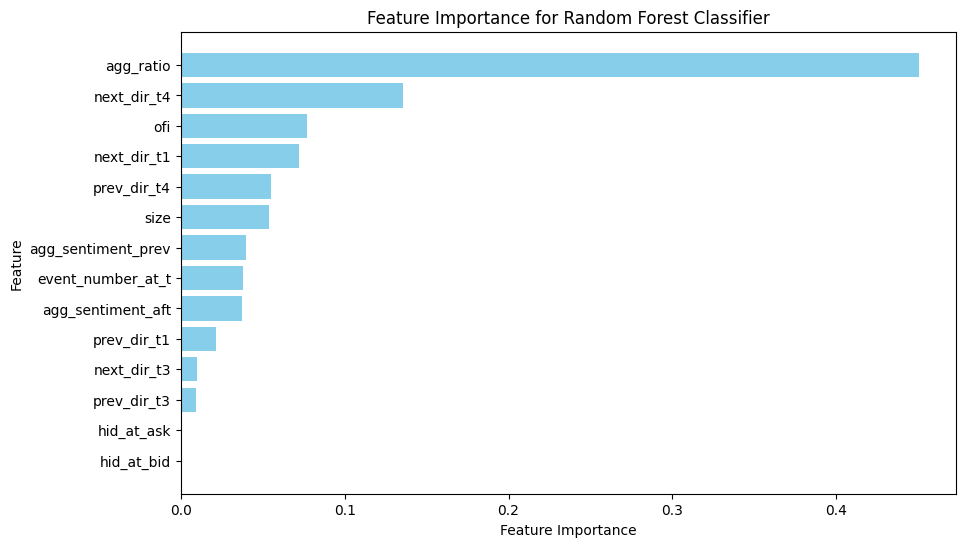

In [35]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Logistic Regression

In [36]:
X_train_lr = X_train.drop(columns=['size', 'event_number_at_t'])
X_test_lr = X_test.drop(columns=['size', 'event_number_at_t'])

Accuracy: 0.8345489443378119
Confusion Matrix:
 [[2123  419]
 [ 443 2225]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.84      0.83      2542
           1       0.84      0.83      0.84      2668

    accuracy                           0.83      5210
   macro avg       0.83      0.83      0.83      5210
weighted avg       0.83      0.83      0.83      5210

ROC AUC Score: 0.9178670892720437


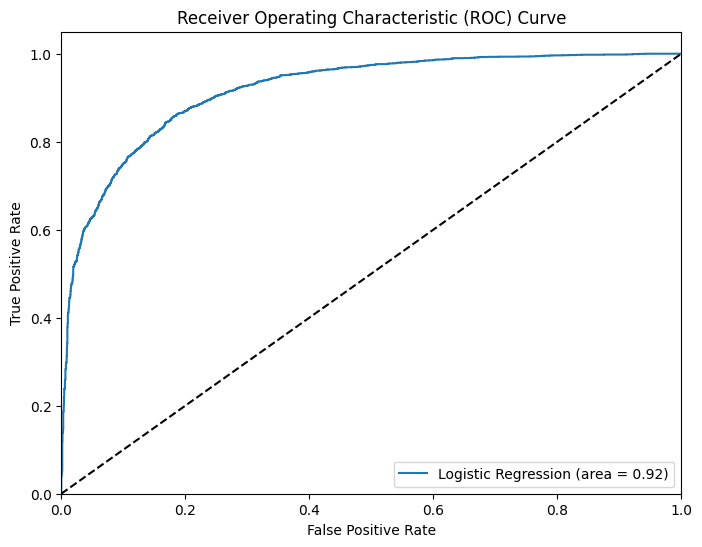

                    Coefficient
ofi                    0.101476
prev_dir_t1           -0.414580
next_dir_t1           -0.611272
prev_dir_t4            0.414619
next_dir_t4            0.465533
next_dir_t3            0.179167
prev_dir_t3            0.229181
agg_sentiment_prev     0.157864
agg_sentiment_aft     -0.011118
agg_ratio             -6.277536
hid_at_bid            -2.312927
hid_at_ask             2.497257


In [37]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(solver='liblinear')

# Fit the model to the training data
logreg.fit(X_train_lr, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_lr)
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the model coefficients (feature importance)
coefficients = pd.DataFrame(logreg.coef_.flatten(), X_train_lr.columns, columns=['Coefficient'])
print(coefficients)

In [38]:
df_predicted_prob = pd.DataFrame(index=X_test_lr.index, data={'probabilities': y_pred_prob, 'predicted_dir':y_pred, 'true_dir':y_test})
df_predicted_prob

,,,probabilities,predicted_dir,true_dir
datetime,ticker,event_number,,,
2012-06-21 15:28:04.034923177,INTC,0,0.796216,1,1
2012-06-21 10:21:28.527662833,AAPL,2,0.991210,1,1
2012-06-21 14:47:44.394241923,INTC,0,0.137760,-1,-1
2012-06-21 14:03:02.297745768,INTC,0,0.384823,-1,-1
2012-06-21 15:38:38.345504779,INTC,0,0.213539,-1,-1
...,...,...,...,...,...
2012-06-21 09:52:04.992595849,AAPL,0,0.006773,-1,-1
2012-06-21 09:51:30.374351444,AAPL,1,0.946238,1,1
2012-06-21 13:52:42.651090805,AAPL,1,0.914330,1,1


In [39]:
df_predicted_prob['diff_from_rand'] = (df_predicted_prob['probabilities'] - 0.5).abs()
df_predicted_prob.sort_values(by='diff_from_rand')

,,,probabilities,predicted_dir,true_dir,diff_from_rand
datetime,ticker,event_number,,,,
2012-06-21 11:48:39.261491017,AAPL,1,0.499586,-1,1,0.000414
2012-06-21 10:53:38.180453059,MSFT,0,0.499358,-1,1,0.000642
2012-06-21 12:23:36.912921609,AAPL,0,0.501111,1,1,0.001111
2012-06-21 15:32:59.214826862,INTC,0,0.501122,1,1,0.001122
2012-06-21 13:41:39.254866627,AAPL,0,0.501382,1,-1,0.001382
...,...,...,...,...,...,...
2012-06-21 12:43:54.259217264,GOOG,1,0.996553,1,1,0.496553
2012-06-21 11:09:05.863813552,GOOG,2,0.996715,1,1,0.496715
2012-06-21 14:24:15.249327321,GOOG,1,0.003101,-1,-1,0.496899


In [40]:
specific_timestamp = pd.Timestamp('2012-06-21 11:48:39.261491017')
df_m_mh.index.get_loc((specific_timestamp, 'AAPL', 1))
# SPY_m[SPY_m.index.get_level_values('datetime') == specific_timestamp]

1017786

Infer direction of hidden liquidity execution when there is an event type 4 happening at the same time frame (tag as same direction)

In [41]:
mult_event_hid_idx = df_m_mh.index.get_level_values('datetime').isin(df_m_mh[df_m_mh['event_number_at_t'] != 1].index.get_level_values('datetime'))

In [42]:
idx_mult_event_buy_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_event_sell_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [43]:
dt_mult_event_buy_vis = idx_mult_event_buy_vis.get_level_values('datetime').unique()
dt_mult_event_sell_vis = idx_mult_event_sell_vis.get_level_values('datetime').unique()

In [44]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_buy_vis), 'predicted_dir'] = 1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_sell_vis), 'predicted_dir'] = -1

In [45]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8556621880998081

Infer direction of hidden liquidity execution when there is an event type 1 happening at the same time frame (tag as opposite direction)

In [46]:
idx_mult_sub_buy = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_sub_sell = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [47]:
dt_mult_sub_buy = idx_mult_sub_buy.get_level_values('datetime').unique()
dt_mult_sub_sell = idx_mult_sub_sell.get_level_values('datetime').unique()

In [48]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_buy), 'predicted_dir'] = -1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_sell), 'predicted_dir'] = 1

In [49]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8573896353166987

Exploratory Data - for OFI

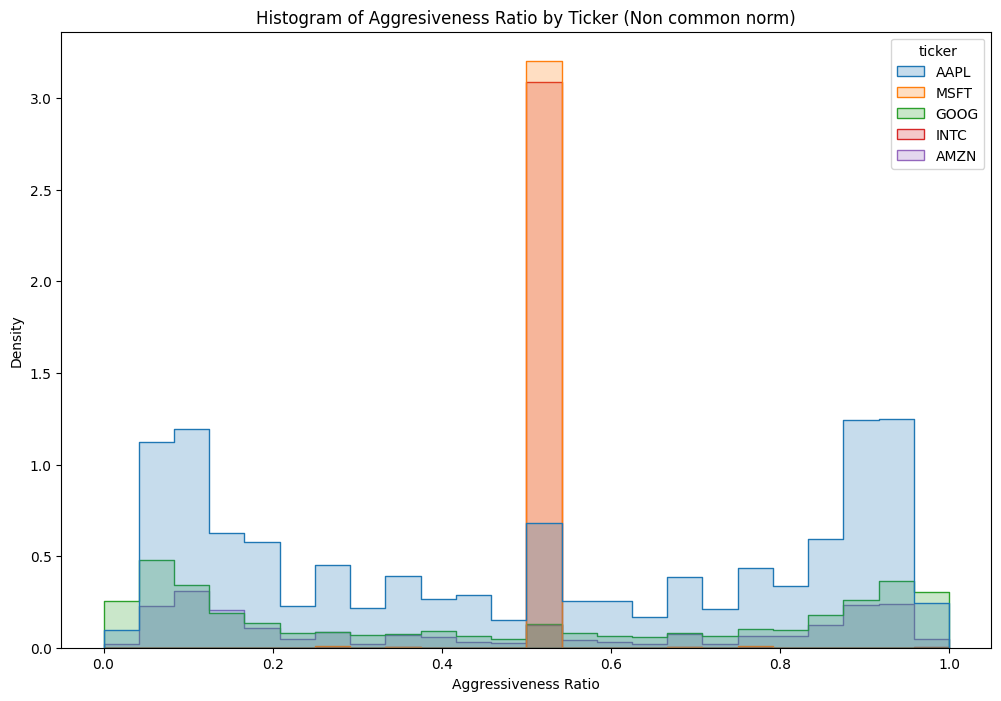

In [50]:
plt.figure(figsize=(12, 8))
sns.histplot(data=X_train, x='agg_ratio', hue='ticker', element='step', stat='density')

plt.xlabel('Aggressiveness Ratio')
plt.ylabel('Density')
plt.title('Histogram of Aggresiveness Ratio by Ticker (Non common norm)')
plt.show()

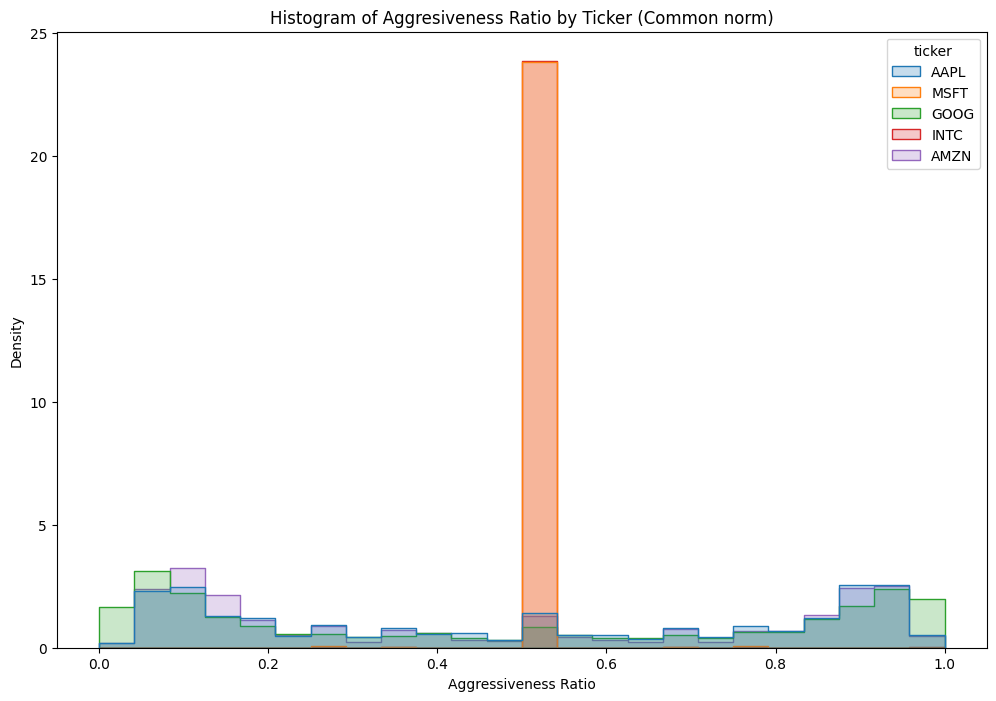

In [51]:
plt.figure(figsize=(12, 8))
sns.histplot(data=X_train, x='agg_ratio', hue='ticker', element='step', stat='density', common_norm=False)

plt.xlabel('Aggressiveness Ratio')
plt.ylabel('Density')
plt.title('Histogram of Aggresiveness Ratio by Ticker (Common norm)')
plt.show()

In [52]:
df_predicted_prob['correct_pred'] = df_predicted_prob['true_dir'] == df_predicted_prob['predicted_dir']

Text(0.5, 1.0, 'Accuracy by Ticker')

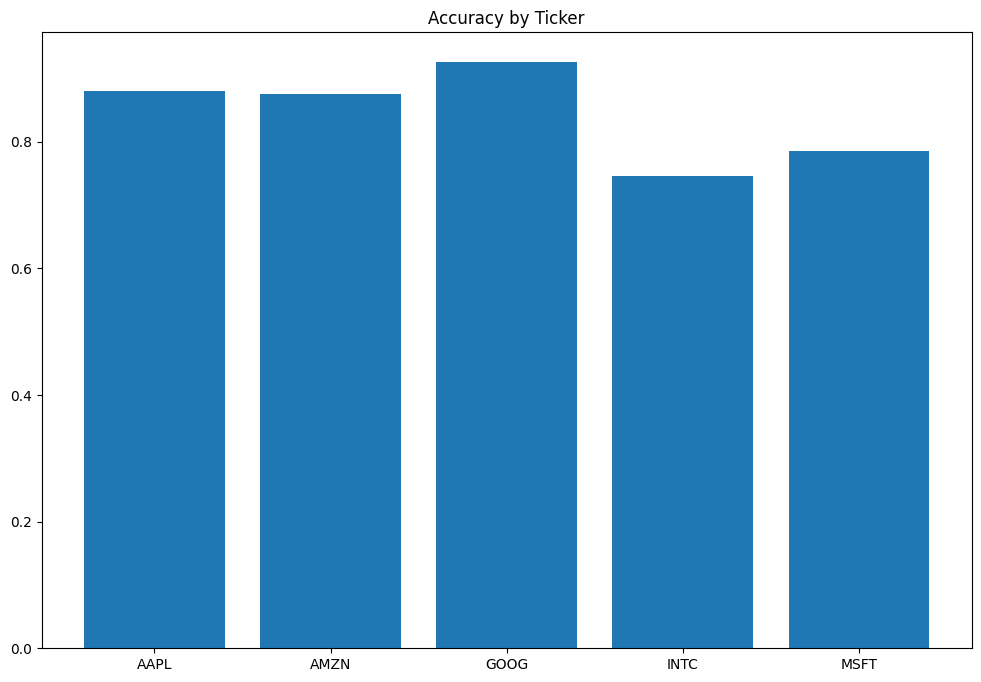

In [523]:
plt.figure(figsize=(12, 8))
plt.bar(df_predicted_prob.groupby('ticker')['correct_pred'].mean().index, df_predicted_prob.groupby('ticker')['correct_pred'].mean())
plt.title("Accuracy by Ticker")

We want to see the success probability of prediction by width of spread. This gives us a better idea of how well our ML model does depending on spread/ liquidity.

In [54]:
df_predicted_analysis = df_predicted_prob.merge(df_ob_mh[['ask_price_1', 'bid_price_1']], left_index=True,
                                                     right_index=True)
df_predicted_analysis['BA_spread'] = df_predicted_analysis['ask_price_1'] - df_predicted_analysis['bid_price_1']

In [55]:
df_predicted_analysis[['BA_spread', 'correct_pred']]

,,,BA_spread,correct_pred
datetime,ticker,event_number,,
2012-06-21 15:28:04.034923177,INTC,0,100,True
2012-06-21 10:21:28.527662833,AAPL,2,1900,True
2012-06-21 14:47:44.394241923,INTC,0,100,True
2012-06-21 14:03:02.297745768,INTC,0,100,True
2012-06-21 15:38:38.345504779,INTC,0,100,True
...,...,...,...,...
2012-06-21 09:52:04.992595849,AAPL,0,1300,True
2012-06-21 09:51:30.374351444,AAPL,1,1700,True
2012-06-21 13:52:42.651090805,AAPL,1,1100,True


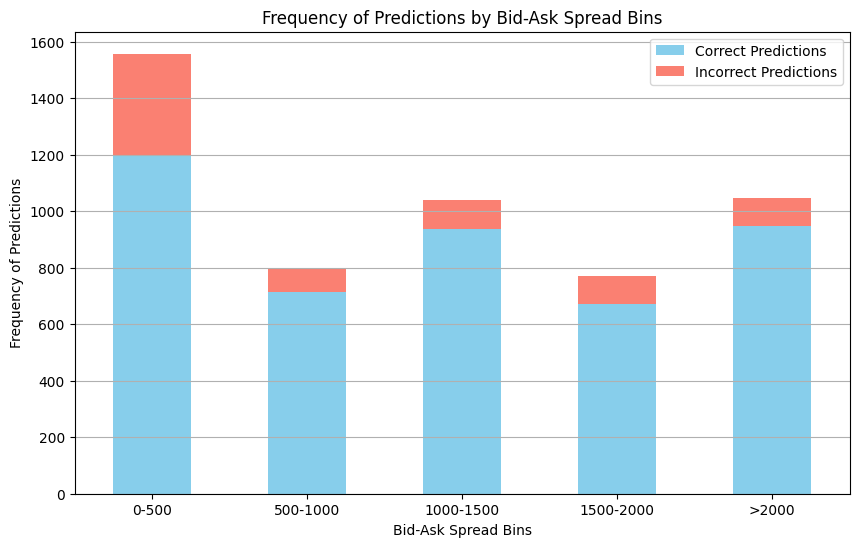

In [57]:
# Binning the BA_spread column
bins = [0, 500, 1000, 1500, 2000, float('inf')]
labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '>2000']
df_predicted_analysis['BA_spread_bins'] = pd.cut(df_predicted_analysis['BA_spread'], bins=bins, labels=labels)

# Grouping by BA_spread_bins and correct_pred
spread_counts = df_predicted_analysis.groupby(['BA_spread_bins', 'correct_pred']).size().unstack(fill_value=0)
spread_counts = spread_counts.T.reindex([True, False]).T  # Ensure the correct order

# Plotting
spread_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
plt.title('Frequency of Predictions by Bid-Ask Spread Bins')
plt.xlabel('Bid-Ask Spread Bins')
plt.ylabel('Frequency of Predictions')
plt.xticks(rotation=0)
plt.legend(['Correct Predictions', 'Incorrect Predictions'])
plt.grid(axis='y')

plt.show()

Most spreads are between 0-500 but we see that the model incorrectly predicts the direction the most for these too. This makes sense as the agg_ratio feature becomes less meaningful.

## OFI analysis

We first consider OFI decomposition in terms of lit and hidden order executions.

We filter for hidden and visible trades within market hours.

In [186]:
df_m_vis_trade = df_m_mh[df_m_mh['event_type']==4]
df_m_hid_trade = df_m_mh[df_m_mh['event_type']==5]

df_ob_vis_trade = df_ob_mh.loc[df_m_vis_trade.index]
df_ob_hid_trade = df_ob_mh.loc[df_m_hid_trade.index]

In [187]:
# Iceberg tagging function

delta_iceberg = '1ms'

# Filter event type 4
event_type_4 = df_m_mh[df_m_mh['event_type'] == 4]

# Filter event type 1
event_type_1 = df_m_mh[df_m_mh['event_type'] == 1]

# Sort both DataFrames by datetime
event_type_4 = event_type_4.sort_values(by='datetime')
event_type_1 = event_type_1.sort_values(by='datetime')

# Perform asof merge to find the nearest event type 1 for each event type 4
merged = pd.merge_asof(
    event_type_4,
    event_type_1,
    on='datetime',
    by=['ticker', 'price'],
    direction='forward',
    tolerance=pd.Timedelta(delta_iceberg),
    suffixes=('', '_event_1')
)

event_1_within_delta = merged.loc[merged['direction_event_1'].notna(), 'datetime']

df_m_vis_trade['iceberg'] = 0

df_m_vis_trade.loc[df_m_vis_trade.index.get_level_values('datetime').isin(event_1_within_delta), 'iceberg'] = 1


In [188]:
# Visible trade messages for each ticker

msft_m_vis_trade = df_m_vis_trade[df_m_vis_trade.index.get_level_values('ticker') == 'MSFT']
goog_m_vis_trade = df_m_vis_trade[df_m_vis_trade.index.get_level_values('ticker') == 'GOOG']
aapl_m_vis_trade = df_m_vis_trade[df_m_vis_trade.index.get_level_values('ticker') == 'AAPL']
intc_m_vis_trade = df_m_vis_trade[df_m_vis_trade.index.get_level_values('ticker') == 'INTC']
amzn_m_vis_trade = df_m_vis_trade[df_m_vis_trade.index.get_level_values('ticker') == 'AMZN']

msft_ob_vis_trade = df_ob_vis_trade[df_ob_vis_trade.index.get_level_values('ticker') == 'MSFT']
goog_ob_vis_trade = df_ob_vis_trade[df_ob_vis_trade.index.get_level_values('ticker') == 'GOOG']
aapl_ob_vis_trade = df_ob_vis_trade[df_ob_vis_trade.index.get_level_values('ticker') == 'AAPL']
intc_ob_vis_trade = df_ob_vis_trade[df_ob_vis_trade.index.get_level_values('ticker') == 'INTC']
amzn_ob_vis_trade = df_ob_vis_trade[df_ob_vis_trade.index.get_level_values('ticker') == 'AMZN']

In [189]:
# Hidden trade messages for each ticker

msft_m_hid_trade = df_m_hid_trade[df_m_hid_trade.index.get_level_values('ticker') == 'MSFT']
goog_m_hid_trade = df_m_hid_trade[df_m_hid_trade.index.get_level_values('ticker') == 'GOOG']
aapl_m_hid_trade = df_m_hid_trade[df_m_hid_trade.index.get_level_values('ticker') == 'AAPL']
intc_m_hid_trade = df_m_hid_trade[df_m_hid_trade.index.get_level_values('ticker') == 'INTC']
amzn_m_hid_trade = df_m_hid_trade[df_m_hid_trade.index.get_level_values('ticker') == 'AMZN']

msft_ob_hid_trade = df_ob_hid_trade[df_ob_hid_trade.index.get_level_values('ticker') == 'MSFT']
goog_ob_hid_trade = df_ob_hid_trade[df_ob_hid_trade.index.get_level_values('ticker') == 'GOOG']
aapl_ob_hid_trade = df_ob_hid_trade[df_ob_hid_trade.index.get_level_values('ticker') == 'AAPL']
intc_ob_hid_trade = df_ob_hid_trade[df_ob_hid_trade.index.get_level_values('ticker') == 'INTC']
amzn_ob_hid_trade = df_ob_hid_trade[df_ob_hid_trade.index.get_level_values('ticker') == 'AMZN']

We focus on checking for hidden icebergs within GOOG, then we generalise by writting a function for it. This is an approximation we make.

We calculate the order imbalance within a delta bucket, get the first and last midprice within the bucket. Then we compute log returns through log(last_midprice) - log(first_midprice).

In [440]:
# Calculate Order Imbalance Function with iceberg tagging

def order_imbalance(df, delta, iceberg=False):
    # Create 30-second intervals
    df['datetime_bins'] = df.index.get_level_values('datetime').ceil(delta)

    # Group by the 30-second intervals and calculate the sums for each direction
    if not iceberg:
        grouped = df.groupby('datetime_bins').apply(
            lambda x: pd.Series({
                'order_imbalance': (x.loc[x['direction'] == -1, 'size'].sum() - x.loc[x['direction'] == 1, 'size'].sum()) /
                                (x.loc[x['direction'] == -1, 'size'].sum() + x.loc[x['direction'] == 1, 'size'].sum()),
                'first_midprice': x['midprice'].iloc[0],
                'last_midprice': x['midprice'].iloc[-1]
            })
        ).reset_index()
        grouped['order_imbalance'] = grouped['order_imbalance'].fillna(0)

    
    else:
        grouped = df.groupby('datetime_bins').apply(
            lambda x: pd.Series({
                'order_imbalance': (x.loc[(x['direction'] == -1) & (~x['iceberg']), 'size'].sum() 
                                    - x.loc[(x['direction'] == 1) & (~x['iceberg']), 'size'].sum()) /
                                   (x.loc[(x['direction'] == -1) & (~x['iceberg']), 'size'].sum() 
                                    + x.loc[(x['direction'] == 1) & (~x['iceberg']), 'size'].sum()),
                'order_imbalance_ib': (x.loc[(x['direction'] == -1) & (x['iceberg']), 'size'].sum() 
                                    - x.loc[(x['direction'] == 1) & (x['iceberg']), 'size'].sum()) /
                                   (x.loc[(x['direction'] == -1) & (x['iceberg']), 'size'].sum() 
                                    + x.loc[(x['direction'] == 1) & (x['iceberg']), 'size'].sum()),
                'first_midprice': x['midprice'].iloc[0],
                'last_midprice': x['midprice'].iloc[-1]
            })
        ).reset_index()
        grouped['order_imbalance'] = grouped['order_imbalance'].fillna(0)
        grouped['order_imbalance_ib'] = grouped['order_imbalance_ib'].fillna(0)



    grouped['log_ret'] = np.log(grouped['last_midprice']) - np.log(grouped['first_midprice'])
    grouped['pricechange_ratio'] = (grouped['last_midprice'] - grouped['first_midprice']) / grouped['first_midprice']

    return grouped


In [526]:
delta = '15S'
goog_vis_imb = order_imbalance(goog_m_vis_trade, delta)
msft_vis_imb = order_imbalance(msft_m_vis_trade, delta)
aapl_vis_imb = order_imbalance(aapl_m_vis_trade, delta)
intc_vis_imb = order_imbalance(intc_m_vis_trade, delta)
amzn_vis_imb = order_imbalance(amzn_m_vis_trade, delta)

df_imb_comb_ib = pd.concat([goog_vis_imb, msft_vis_imb, aapl_vis_imb, intc_vis_imb, amzn_vis_imb])

In [531]:
lm_OI = smf.ols(formula="""log_ret ~ order_imbalance""", data=amzn_vis_imb).fit()
lm_OI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ret   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     323.7
Date:                Sat, 13 Jul 2024   Prob (F-statistic):           3.13e-63
Time:                        16:56:53   Log-Likelihood:                 6968.5
No. Observations:                1044   AIC:                        -1.393e+04
Df Residuals:                    1042   BIC:                        -1.392e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        9.376e-07   9.47e-06      0.099      0.921   -1.77e-05    1.95e-05
order_imbalance     0.0002   1.06e-05     17.991      0.000       0.000       0.000
==============================================================================
Omnibus:                      284.132   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8795.254
Skew:                           0.579   Prob(JB):                         0.00
Kurtosis:                      17.172   Cond. No.                         1.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
# Calculate dataframe for OI for hidden liquidity

delta_hid = '5min'
goog_hid_imb = order_imbalance(goog_m_hid_trade, delta_hid)
msft_hid_imb = order_imbalance(msft_m_hid_trade, delta_hid)
aapl_hid_imb = order_imbalance(aapl_m_hid_trade, delta_hid)
intc_hid_imb = order_imbalance(intc_m_hid_trade, delta_hid)
amzn_hid_imb = order_imbalance(amzn_m_hid_trade, delta_hid)

In [194]:
est = []
t_stat = []

df_lst = [goog_hid_imb, aapl_hid_imb, msft_hid_imb,
          intc_hid_imb, amzn_hid_imb]
for df in df_lst:
    lm = smf.ols(formula="""log_ret ~ order_imbalance""", data=df).fit()
    est.append(lm.params[1])
    t_stat.append((lm.tvalues[1], lm.pvalues[1]))
    

In [195]:
t_stat

[(np.float64(1.0736995974797028), np.float64(0.28649372626772335)),
 (np.float64(2.2951310229584596), np.float64(0.024601330141731537)),
 (np.float64(0.3701432822600814), np.float64(0.7123474923771864)),
 (np.float64(0.6705002661145402), np.float64(0.5046547146699496)),
 (np.float64(1.232816813774049), np.float64(0.22159957872764488))]

In [334]:
# # Combine hidden and visible liquidity OI for regression

# delta_joined = '5min'

# goog_vis_imb_comb = order_imbalance(goog_m_vis_trade, delta_joined)
# goog_hid_imb_comb = order_imbalance(goog_m_hid_trade, delta_joined)

# amzn_vis_imb_comb = order_imbalance(amzn_m_vis_trade, delta_joined)
# amzn_hid_imb_comb = order_imbalance(amzn_m_hid_trade, delta_joined)

# intc_vis_imb_comb = order_imbalance(intc_m_vis_trade, delta_joined)
# intc_hid_imb_comb = order_imbalance(intc_m_hid_trade, delta_joined)

# aapl_vis_imb_comb = order_imbalance(aapl_m_vis_trade, delta_joined)
# aapl_hid_imb_comb = order_imbalance(aapl_m_hid_trade, delta_joined)

# msft_vis_imb_comb = order_imbalance(msft_m_vis_trade, delta_joined)
# msft_hid_imb_comb = order_imbalance(msft_m_hid_trade, delta_joined)

# google_imb_comb = goog_vis_imb_comb.merge(goog_hid_imb_comb[['order_imbalance', 'datetime_bins']], 
#                                           left_on='datetime_bins', right_on='datetime_bins')
# amzn_imb_comb = amzn_vis_imb_comb.merge(amzn_hid_imb_comb[['order_imbalance', 'datetime_bins']], 
#                                           left_on='datetime_bins', right_on='datetime_bins')
# intc_imb_comb = intc_vis_imb_comb.merge(intc_hid_imb_comb[['order_imbalance', 'datetime_bins']], 
#                                           left_on='datetime_bins', right_on='datetime_bins')
# aapl_imb_comb = aapl_vis_imb_comb.merge(aapl_hid_imb_comb[['order_imbalance', 'datetime_bins']], 
#                                           left_on='datetime_bins', right_on='datetime_bins')
# msft_imb_comb = msft_vis_imb_comb.merge(msft_hid_imb_comb[['order_imbalance', 'datetime_bins']], 
#                                           left_on='datetime_bins', right_on='datetime_bins')



# google_imb_comb.rename(columns={'order_imbalance_x': 'order_imbalance_vis', 'order_imbalance_y': 'order_imbalance_hid'}, 
#                        inplace=True)
# amzn_imb_comb.rename(columns={'order_imbalance_x': 'order_imbalance_vis', 'order_imbalance_y': 'order_imbalance_hid'}, 
#                        inplace=True)
# intc_imb_comb.rename(columns={'order_imbalance_x': 'order_imbalance_vis', 'order_imbalance_y': 'order_imbalance_hid'}, 
#                        inplace=True)
# aapl_imb_comb.rename(columns={'order_imbalance_x': 'order_imbalance_vis', 'order_imbalance_y': 'order_imbalance_hid'}, 
#                        inplace=True)
# msft_imb_comb.rename(columns={'order_imbalance_x': 'order_imbalance_vis', 'order_imbalance_y': 'order_imbalance_hid'}, 
#                        inplace=True)


# df_lst = [google_imb_comb, amzn_imb_comb, intc_imb_comb, aapl_imb_comb, msft_imb_comb]

# for df in df_lst:
#     df['stan_OI_vis'] = (df['order_imbalance_vis'] - df['order_imbalance_vis'].mean()) / df['order_imbalance_vis'].std()
#     df['stan_OI_hid'] = (df['order_imbalance_hid'] - df['order_imbalance_hid'].mean()) / df['order_imbalance_hid'].std()
#     df['stan_log_ret'] = (df['log_ret'] - df['log_ret'].mean()) / df['log_ret'].std()


# df_comb = pd.concat([google_imb_comb, amzn_imb_comb, intc_imb_comb, aapl_imb_comb, msft_imb_comb])

In [460]:
stock_data = {
    'goog': {'visible': goog_m_vis_trade, 'hidden': goog_m_hid_trade},
    'aapl': {'visible': aapl_m_vis_trade, 'hidden': aapl_m_hid_trade},
    'msft': {'visible': msft_m_vis_trade, 'hidden': msft_m_hid_trade},
    'intc': {'visible': intc_m_vis_trade, 'hidden': intc_m_hid_trade},
    'amzn': {'visible': amzn_m_vis_trade, 'hidden': amzn_m_hid_trade}
}

In [499]:
# Function for Standardising and combining df. Important!!!

def standardize_column(df, column_name):
    return (df[column_name] - df[column_name].mean()) / df[column_name].std()

def combine_hidden_visible_liquidity_OI_for_regression(stock_data, order_imbalance_func1, order_imbalance_func2, delta='1min',
                                                       hid_col=['order_imbalance', 'datetime_bins'], rename=True,
                                                       standardise=True):
    stock_keys = stock_data.keys()
    vis_imb_comb = {key: order_imbalance_func1(stock_data[key]['visible'], delta) for key in stock_keys}
    hid_imb_comb = {key: order_imbalance_func2(stock_data[key]['hidden'], delta) for key in stock_keys}

    # Combine visible and hidden imbalances
    imb_comb = {}
    for key in stock_keys:
        combined = vis_imb_comb[key].merge(hid_imb_comb[key][hid_col],
                                           left_on='datetime_bins', right_on='datetime_bins')
        if rename:
            combined.rename(columns={'order_imbalance_x': 'order_imbalance_vis',
                                    'order_imbalance_y': 'order_imbalance_hid'}, inplace=True)
        imb_comb[key] = combined

    # Standardize columns
    if standardise:
        for key in stock_keys:
            df = imb_comb[key]
            df['stan_OI_vis'] = standardize_column(df, 'order_imbalance_vis')
            df['stan_OI_hid'] = standardize_column(df, 'order_imbalance_hid')
            df['stan_log_ret'] = standardize_column(df, 'log_ret')

    # Concatenate all dataframes
    df_comb = pd.concat([imb_comb[key] for key in stock_keys])

    return df_comb, imb_comb

In [477]:
df_combined, ticker_dfs = combine_hidden_visible_liquidity_OI_for_regression(stock_data, order_imbalance, delta='1min')

In [479]:
# Calculate estimates for regression and t values

est = []
t_stat1 = []
t_stat2 = []

for df in ticker_dfs.values():
    lm = smf.ols(formula="""log_ret ~ order_imbalance_vis + order_imbalance_hid""", data=df).fit()
    est.append((lm.params[1], lm.params[2]))
    t_stat1.append((lm.tvalues[1], lm.pvalues[1]))
    t_stat2.append((lm.tvalues[2], lm.pvalues[2]))

In [480]:
est

[(np.float64(0.00039788023370955895), np.float64(4.3899100462326386e-05)),
 (np.float64(0.0005560258024800412), np.float64(6.724727677820798e-05)),
 (np.float64(0.0005687595370519624), np.float64(5.5030613572382064e-05)),
 (np.float64(0.0005051128652418857), np.float64(8.975599831043842e-05)),
 (np.float64(0.0005817993824035234), np.float64(7.70054245571808e-05))]

In [466]:
t_stat1

[(np.float64(11.02082823187852), np.float64(1.1074308496999492e-25)),
 (np.float64(16.14946390407369), np.float64(2.119358044409342e-50)),
 (np.float64(14.425335197767795), np.float64(5.097864593041212e-40)),
 (np.float64(12.77200843809928), np.float64(3.703278022113165e-32)),
 (np.float64(12.670038265769332), np.float64(6.494222283711184e-32))]

In [467]:
t_stat2

[(np.float64(1.4239861788819068), np.float64(0.15501143028803557)),
 (np.float64(2.1902943501557), np.float64(0.028818081804425508)),
 (np.float64(1.9593579452955274), np.float64(0.05059564870090815)),
 (np.float64(4.052813662633597), np.float64(5.94711714878102e-05)),
 (np.float64(0.5678221243957452), np.float64(0.5704229208494691))]

Check whether they are from the same distribution, if we standardise.

In [310]:
from scipy.stats import anderson_ksamp

for i in range(len(df_lst)):
    for j in range(i+1, len(df_lst)):
        results = anderson_ksamp([df_lst[i]['order_imbalance_vis'], df_lst[j]['order_imbalance_vis']])
        print(f"Statistic: {results.statistic}")
        print(f"P-Value: {results.significance_level}")

Statistic: 52.352221316157234
P-Value: 0.001
Statistic: 17.91243795575737
P-Value: 0.001
Statistic: 1.9021577929175775
P-Value: 0.053411357254243334
Statistic: 2.8384758466928517
P-Value: 0.022528457716221074
Statistic: 11.95781797789056
P-Value: 0.001
Statistic: 27.334352263670603
P-Value: 0.001
Statistic: 31.689500181451418
P-Value: 0.001
Statistic: 6.546632984530607
P-Value: 0.001
Statistic: 6.195506855967896
P-Value: 0.0013258206455938042
Statistic: 1.9091967113691812
P-Value: 0.05305954622362237


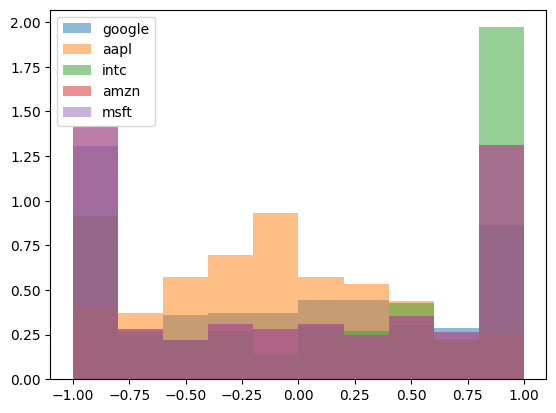

In [481]:
plt.hist(ticker_dfs['goog']['order_imbalance_hid'], alpha=0.5, label='google', density=True)
plt.hist(ticker_dfs['aapl']['order_imbalance_hid'], alpha=0.5, label='aapl', density=True)
plt.hist(ticker_dfs['intc']['order_imbalance_hid'], alpha=0.5, label='intc', density=True)
plt.hist(ticker_dfs['amzn']['order_imbalance_hid'], alpha=0.5, label='amzn', density=True)
plt.hist(ticker_dfs['amzn']['order_imbalance_hid'], alpha=0.5, label='msft', density=True)

plt.legend()

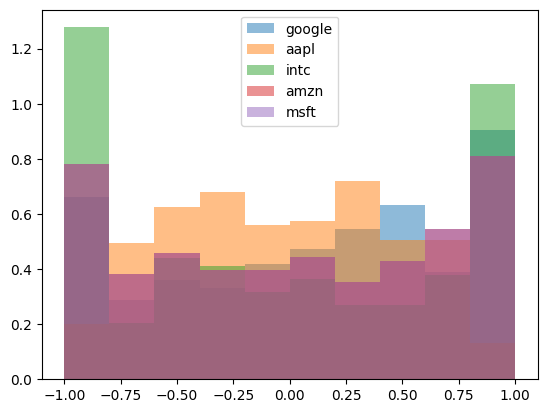

In [482]:
plt.hist(ticker_dfs['goog']['order_imbalance_vis'], alpha=0.5, label='google', density=True)
plt.hist(ticker_dfs['aapl']['order_imbalance_vis'], alpha=0.5, label='aapl', density=True)
plt.hist(ticker_dfs['intc']['order_imbalance_vis'], alpha=0.5, label='intc', density=True)
plt.hist(ticker_dfs['amzn']['order_imbalance_vis'], alpha=0.5, label='amzn', density=True)
plt.hist(ticker_dfs['amzn']['order_imbalance_vis'], alpha=0.5, label='msft', density=True)

plt.legend()

In [483]:
from scipy.stats import anderson_ksamp

for i in range(len(df_lst)):
    for j in range(i+1, len(df_lst)):
        results = anderson_ksamp([df_lst[i]['order_imbalance_hid'], df_lst[j]['order_imbalance_hid']])
        print(f"Statistic: {results.statistic}")
        print(f"P-Value: {results.significance_level}")

Statistic: 0.061665937793117416
P-Value: 0.25
Statistic: 8.2163552117069
P-Value: 0.001
Statistic: 7.257010721704009
P-Value: 0.001
Statistic: 0.00116981476449407
P-Value: 0.25
Statistic: 13.4898773898063
P-Value: 0.001
Statistic: 10.886037903314584
P-Value: 0.001
Statistic: 1.971007081568996
P-Value: 0.050071927049469646
Statistic: 1.2607926424005522
P-Value: 0.09827287235233889
Statistic: 4.959277726781496
P-Value: 0.0035875923358984177
Statistic: 3.252147134015979
P-Value: 0.01554214403626187


In [484]:
for i in range(len(df_lst)):
    for j in range(i+1, len(df_lst)):
        results = anderson_ksamp([df_lst[i]['order_imbalance_vis'], df_lst[j]['order_imbalance_vis']])
        print(f"Statistic: {results.statistic}")
        print(f"P-Value: {results.pvalue}")

Statistic: 2.875449698506365
P-Value: 0.021787707040271675
Statistic: 0.7844449876811049
P-Value: 0.15606693619469142
Statistic: 6.882271469375672
P-Value: 0.001
Statistic: 2.558502732304693
P-Value: 0.029065681426841586
Statistic: -0.34496944050850264
P-Value: 0.25
Statistic: 0.24964181091534202
P-Value: 0.25
Statistic: 0.6557720652753276
P-Value: 0.1770875134651595
Statistic: 2.6138170427539875
P-Value: 0.027632574811158606
Statistic: 1.7219393836279995
P-Value: 0.06329704780064249
Statistic: 0.4980822556824767
P-Value: 0.20691745155534436


In [303]:
from scipy.stats import mannwhitneyu

for i in range(len(df_lst)):
    for j in range(i+1, len(df_lst)):
        statistic, p_value = mannwhitneyu(df_lst[i]['order_imbalance_hid'], df_lst[j]['order_imbalance_hid'], alternative='two-sided')

        print(f"Statistic: {statistic}")
        print(f"P-Value: {p_value}")

Statistic: 3034.0
P-Value: 0.4061550702749873
Statistic: 1915.0
P-Value: 0.0007473862367327655
Statistic: 2234.0
P-Value: 0.029814454999089104
Statistic: 2816.0
P-Value: 0.9910030978180243
Statistic: 1723.0
P-Value: 4.2536009730197355e-05
Statistic: 2106.0
P-Value: 0.007962300967248417
Statistic: 2658.0
P-Value: 0.5626943753322581
Statistic: 2872.0
P-Value: 0.8244967161323031
Statistic: 3602.0
P-Value: 0.0030205746396496334
Statistic: 3336.0
P-Value: 0.04931921322616674


Linear regression for GOOG

Text(0.5, 1.0, 'Scatter plot of Order Imbalance against log returns for MSFT')

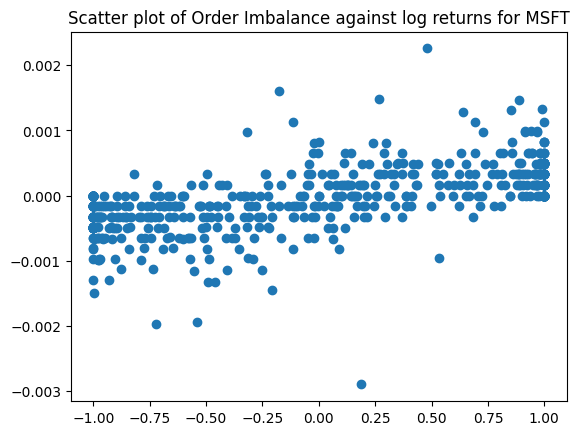

In [68]:
plt.scatter(msft_vis_imb['order_imbalance'], msft_vis_imb['log_ret'])
plt.title("Scatter plot of Order Imbalance against log returns for MSFT")

All variables are significant across tickers.

In [69]:
lm_OI = smf.ols(formula="""log_ret ~ order_imbalance""", data=goog_vis_imb).fit()
lm_OI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     248.5
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           6.46e-48
Time:                        13:51:52   Log-Likelihood:                 4604.2
No. Observations:                 678   AIC:                            -9204.
Df Residuals:                     676   BIC:                            -9195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.962e-05   1.05e-05     -1.866      0.062   -4.03e-05    1.02e-06
order_imbalance     0.0002   1.27e-05     15.765      0.000       0.000       0.000
==============================================================================
Omnibus:                      206.743   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2175.463
Skew:                          -1.043   Prob(JB):                         0.00
Kurtosis:                      11.524   Cond. No.                         1.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
lm_OI = smf.ols(formula="""pricechange_ratio ~ order_imbalance""", data=intc_vis_imb).fit()
lm_OI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pricechange_ratio   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     242.9
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           1.26e-46
Time:                        13:51:52   Log-Likelihood:                 4105.3
No. Observations:                 638   AIC:                            -8207.
Df Residuals:                     636   BIC:                            -8198.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.502e-05   1.55e-05     -1.618      0.106   -5.54e-05    5.35e-06
order_imbalance     0.0003   1.83e-05     15.586      0.000       0.000       0.000
==============================================================================
Omnibus:                      215.691   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1958.329
Skew:                          -1.234   Prob(JB):                         0.00
Kurtosis:                      11.220   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Iceberg decomposition

In [182]:
delta = '5min'
goog_vis_imb_ib = order_imbalance(goog_m_vis_trade, delta, iceberg=True)
msft_vis_imb_ib = order_imbalance(msft_m_vis_trade, delta, iceberg=True)
aapl_vis_imb_ib = order_imbalance(aapl_m_vis_trade, delta, iceberg=True)
intc_vis_imb_ib = order_imbalance(intc_m_vis_trade, delta, iceberg=True)
amzn_vis_imb_ib = order_imbalance(amzn_m_vis_trade, delta, iceberg=True)

df_comb_ib = pd.concat([goog_vis_imb_ib, msft_vis_imb_ib, aapl_vis_imb_ib, intc_vis_imb_ib, amzn_vis_imb_ib])

In [184]:
ib_ols = smf.ols(formula="""pricechange_ratio ~ order_imbalance + order_imbalance_ib""", data=df_comb_ib).fit()
ib_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pricechange_ratio   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     95.03
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           4.60e-34
Time:                        15:15:42   Log-Likelihood:                 2033.3
No. Observations:                 375   AIC:                            -4061.
Df Residuals:                     372   BIC:                            -4049.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0001   5.64e-05     -2.570      0.011      -0.000    -3.4e-05
order_imbalance        0.0019      0.000     13.004      0.000       0.002       0.002
order_imbalance_ib     0.0002   8.84e-05      2.689      0.007    6.39e-05       0.000
==============================================================================
Omnibus:                       43.337   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.307
Skew:                           0.190   Prob(JB):                     6.00e-56
Kurtosis:                       7.016   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We do a t-test to verify results.

In [ ]:
hypothesis = 'order_imbalance_ib - order_imbalance = 0'

# Perform the t-test
t_test_result = ib_ols.t_test(hypothesis)

# Output the t-test results
print(t_test_result)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0017      0.000     -9.256      0.000      -0.002      -0.001


Hidden Orders OFI

Text(0.5, 1.0, 'Scatter plot of Order Imbalance against log returns for MSFT (Hidden)')

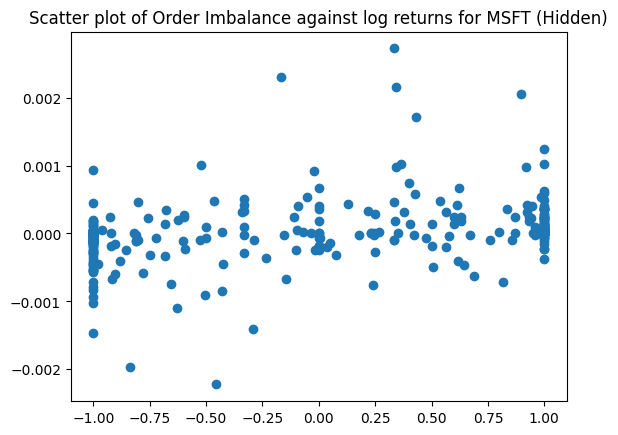

In [ ]:
plt.scatter(amzn_hid_imb['order_imbalance'], amzn_hid_imb['log_ret'])
plt.title("Scatter plot of Order Imbalance against log returns for MSFT (Hidden)")

In [ ]:
smf.ols(formula="""pricechange_ratio ~ order_imbalance""", data=amzn_hid_imb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pricechange_ratio   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     24.74
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           8.28e-07
Time:                        13:14:57   Log-Likelihood:                 4586.0
No. Observations:                 691   AIC:                            -9168.
Df Residuals:                     689   BIC:                            -9159.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         1.07e-05   1.21e-05      0.885      0.377    -1.3e-05    3.44e-05
order_imbalance  6.477e-05    1.3e-05      4.974      0.000    3.92e-05    9.03e-05
==============================================================================
Omnibus:                      342.351   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16403.902
Skew:                           1.461   Prob(JB):                         0.00
Kurtosis:                      26.690   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
smf.ols(formula="""log_ret ~ order_imbalance""", data=goog_hid_imb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     43.85
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           6.35e-11
Time:                        13:14:57   Log-Likelihood:                 5903.2
No. Observations:                 837   AIC:                        -1.180e+04
Df Residuals:                     835   BIC:                        -1.179e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.863e-06    7.3e-06     -1.214      0.225   -2.32e-05    5.46e-06
order_imbalance  5.245e-05   7.92e-06      6.622      0.000    3.69e-05     6.8e-05
==============================================================================
Omnibus:                      659.233   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94859.160
Skew:                          -2.731   Prob(JB):                         0.00
Kurtosis:                      54.867   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Combined Hidden and Visible.

In [ ]:
smf.ols(formula="""log_ret ~ order_imbalance_vis + order_imbalance_hid""", data=google_imb_comb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     115.6
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           2.72e-44
Time:                        13:14:57   Log-Likelihood:                 5024.0
No. Observations:                 728   AIC:                        -1.004e+04
Df Residuals:                     725   BIC:                        -1.003e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -4.124e-07   9.15e-06     -0.045      0.964   -1.84e-05    1.76e-05
order_imbalance_vis     0.0001   1.45e-05      9.550      0.000       0.000       0.000
order_imbalance_hid  2.607e-05   1.39e-05      1.878      0.061   -1.18e-06    5.33e-05
==============================================================================
Omnibus:                      379.002   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29267.486
Skew:                          -1.450   Prob(JB):                         0.00
Kurtosis:                      33.926   Cond. No.                         2.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
smf.ols(formula="""pricechange_ratio ~ order_imbalance_vis + order_imbalance_hid""", data=google_imb_comb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pricechange_ratio   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     115.6
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           2.65e-44
Time:                        13:14:57   Log-Likelihood:                 5024.2
No. Observations:                 728   AIC:                        -1.004e+04
Df Residuals:                     725   BIC:                        -1.003e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -3.726e-07   9.15e-06     -0.041      0.968   -1.83e-05    1.76e-05
order_imbalance_vis     0.0001   1.45e-05      9.551      0.000       0.000       0.000
order_imbalance_hid  2.608e-05   1.39e-05      1.879      0.061   -1.17e-06    5.33e-05
==============================================================================
Omnibus:                      377.195   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29120.662
Skew:                          -1.439   Prob(JB):                         0.00
Kurtosis:                      33.850   Cond. No.                         2.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We look at combining all tickers.

In [ ]:
df_comb_vis_imb = pd.concat([goog_vis_imb, amzn_vis_imb, msft_vis_imb, intc_vis_imb,
                             aapl_vis_imb])

df_comb_hid_imb = pd.concat([goog_hid_imb, amzn_hid_imb, msft_hid_imb, intc_hid_imb,
                             aapl_hid_imb])

### Fit of Visible Orders

In [ ]:
smf.ols(formula="""pricechange_ratio ~ order_imbalance""", data=df_comb_vis_imb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      pricechange_ratio   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     179.8
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           9.76e-34
Time:                        13:14:57   Log-Likelihood:                 2029.7
No. Observations:                 375   AIC:                            -4055.
Df Residuals:                     373   BIC:                            -4048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0001   5.66e-05     -2.290      0.023      -0.000   -1.83e-05
order_imbalance     0.0020      0.000     13.410      0.000       0.002       0.002
==============================================================================
Omnibus:                       45.811   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.773
Skew:                           0.215   Prob(JB):                     3.95e-62
Kurtosis:                       7.232   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
smf.ols(formula="""log_ret ~ order_imbalance""", data=df_comb_vis_imb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     179.8
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           9.67e-34
Time:                        13:14:57   Log-Likelihood:                 2029.6
No. Observations:                 375   AIC:                            -4055.
Df Residuals:                     373   BIC:                            -4047.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0001   5.66e-05     -2.305      0.022      -0.000   -1.92e-05
order_imbalance     0.0020      0.000     13.411      0.000       0.002       0.002
==============================================================================
Omnibus:                       45.212   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.351
Skew:                           0.202   Prob(JB):                     3.60e-61
Kurtosis:                       7.201   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fit of hidden models

In [ ]:
smf.ols(formula="""log_ret ~ order_imbalance""", data=df_comb_hid_imb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     210.6
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           1.18e-46
Time:                        13:14:57   Log-Likelihood:                 30308.
No. Observations:                4378   AIC:                        -6.061e+04
Df Residuals:                    4376   BIC:                        -6.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.204e-06   3.61e-06     -1.443      0.149   -1.23e-05    1.86e-06
order_imbalance  5.992e-05   4.13e-06     14.514      0.000    5.18e-05     6.8e-05
==============================================================================
Omnibus:                     1282.777   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159747.184
Skew:                          -0.207   Prob(JB):                         0.00
Kurtosis:                      32.590   Cond. No.                         1.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Combined hidden - Imbalance vs Price Change Ratio')

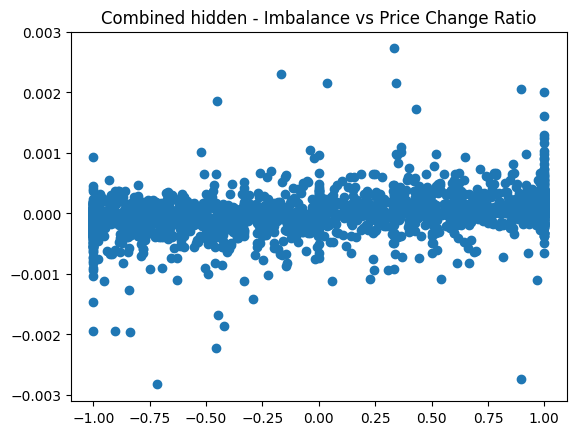

In [ ]:
plt.scatter(df_comb_hid_imb['order_imbalance'], df_comb_hid_imb['pricechange_ratio'])
plt.title('Combined hidden - Imbalance vs Price Change Ratio')

Text(0.5, 1.0, 'Combined Visible - Imbalance vs Price Change Ratio')

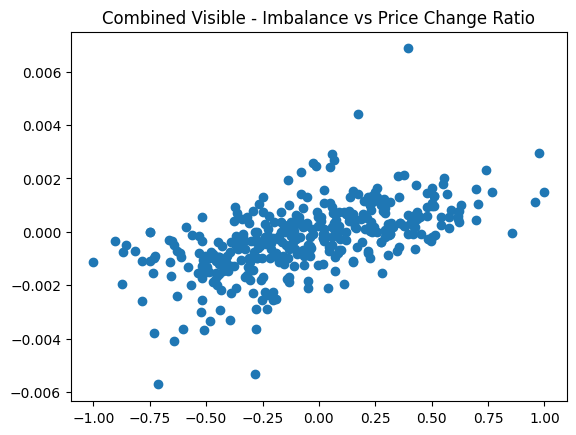

In [ ]:
plt.scatter(df_comb_vis_imb['order_imbalance'], df_comb_vis_imb['pricechange_ratio'])
plt.title('Combined Visible - Imbalance vs Price Change Ratio')

## Combined vis and hid, with full dataframe

We see that a shorter time frame makes it significant. When the time frame is longer, then it becomes insignificant. Consider delta=15S.

In [ ]:
smf.ols(formula="""log_ret ~ order_imbalance_vis + order_imbalance_hid""", data=df_comb).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pricechange   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     460.5
Date:                Thu, 11 Jul 2024   Prob (F-statistic):          4.28e-177
Time:                        13:14:58   Log-Likelihood:                 22779.
No. Observations:                3299   AIC:                        -4.555e+04
Df Residuals:                    3296   BIC:                        -4.553e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -5.859e-06   4.23e-06     -1.385      0.166   -1.42e-05    2.44e-06
order_imbalance_vis     0.0001   4.98e-06     27.470      0.000       0.000       0.000
order_imbalance_hid   2.27e-05   5.09e-06      4.461      0.000    1.27e-05    3.27e-05
==============================================================================
Omnibus:                     1708.261   Durbin-Watson:                   2.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           164261.720
Skew:                          -1.532   Prob(JB):                         0.00
Kurtosis:                      37.433   Cond. No.                         1.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [385]:
delta_joined = '30S'

goog_vis_imb_comb_ib = order_imbalance(goog_m_vis_trade, delta_joined, True)
goog_hid_imb_comb_ib = order_imbalance(goog_m_hid_trade, delta_joined)

msft_vis_imb_comb_ib = order_imbalance(msft_m_vis_trade, delta_joined, True)
msft_hid_imb_comb_ib = order_imbalance(msft_m_hid_trade, delta_joined)

aapl_vis_imb_comb_ib = order_imbalance(aapl_m_vis_trade, delta_joined, True)
aapl_hid_imb_comb_ib = order_imbalance(aapl_m_hid_trade, delta_joined)

intc_vis_imb_comb_ib = order_imbalance(intc_m_vis_trade, delta_joined, True)
intc_hid_imb_comb_ib = order_imbalance(intc_m_hid_trade, delta_joined)

amzn_vis_imb_comb_ib = order_imbalance(amzn_m_vis_trade, delta_joined, True)
amzn_hid_imb_comb_ib = order_imbalance(amzn_m_hid_trade, delta_joined)

goog_imb_comb_ib = goog_vis_imb_comb_ib.merge(goog_hid_imb_comb_ib[['datetime_bins', 'order_imbalance']], 
                                              left_on='datetime_bins', right_on='datetime_bins')
msft_imb_comb_ib = msft_vis_imb_comb_ib.merge(msft_hid_imb_comb_ib[['datetime_bins', 'order_imbalance']], 
                                              left_on='datetime_bins', right_on='datetime_bins')
aapl_imb_comb_ib = aapl_vis_imb_comb_ib.merge(aapl_hid_imb_comb_ib[['datetime_bins', 'order_imbalance']], 
                                              left_on='datetime_bins', right_on='datetime_bins')
intc_imb_comb_ib = intc_vis_imb_comb_ib.merge(intc_hid_imb_comb_ib[['datetime_bins', 'order_imbalance']], 
                                              left_on='datetime_bins', right_on='datetime_bins')
amzn_imb_comb_ib = amzn_vis_imb_comb_ib.merge(amzn_hid_imb_comb_ib[['datetime_bins', 'order_imbalance']], 
                                              left_on='datetime_bins', right_on='datetime_bins')



goog_imb_comb_ib.rename(columns={'order_imbalance_x': 'order_imbalance_lit', 'order_imbalance_y': 'order_imbalance_hid'},
                        inplace=True)
aapl_imb_comb_ib.rename(columns={'order_imbalance_x': 'order_imbalance_lit', 'order_imbalance_y': 'order_imbalance_hid'},
                        inplace=True)
intc_imb_comb_ib.rename(columns={'order_imbalance_x': 'order_imbalance_lit', 'order_imbalance_y': 'order_imbalance_hid'},
                        inplace=True)
amzn_imb_comb_ib.rename(columns={'order_imbalance_x': 'order_imbalance_lit', 'order_imbalance_y': 'order_imbalance_hid'},
                        inplace=True)
msft_imb_comb_ib.rename(columns={'order_imbalance_x': 'order_imbalance_lit', 'order_imbalance_y': 'order_imbalance_hid'},
                        inplace=True)

df_comb_ib = pd.concat([goog_imb_comb_ib, aapl_imb_comb_ib, intc_imb_comb_ib, amzn_imb_comb_ib, msft_imb_comb_ib])

In [386]:
df_lst_ib = [goog_imb_comb_ib, aapl_imb_comb_ib, intc_imb_comb_ib, amzn_imb_comb_ib, msft_imb_comb_ib]

In [387]:
est1 = []
est2 = []
est3 = []

for df in df_lst_ib:
    lm = smf.ols(formula="""log_ret ~ order_imbalance_lit + order_imbalance_hid + order_imbalance_ib""", data=df).fit()
    est1.append((lm.params[1], lm.tvalues[1]))
    est2.append((lm.params[2], lm.tvalues[2]))
    est3.append((lm.params[3], lm.tvalues[3]))

df_lm_ib_est = pd.DataFrame({'Tickers': ['GOOG', 'AAPL', 'INTC', 'AMZN', 'MSFT'],
                             'est_lit': [i[0] for i in est1],
                             'tval_lit': [i[1] for i in est1],
                             'est_hid': [i[0] for i in est2],
                             'tval_hid': [i[1] for i in est2],
                             'est_ib': [i[0] for i in est3],
                             'tval_ib': [i[1] for i in est3]})


In [388]:
df_lm_ib_est

,Tickers,est_lit,tval_lit,est_hid,tval_hid,est_ib,tval_ib
0,GOOG,0.000213,11.707983,0.000023,1.309519,0.000030,1.234265
1,AAPL,0.000283,17.371036,0.000032,1.990427,0.000047,3.328697
2,INTC,0.000240,10.088980,0.000083,3.447189,0.000158,5.744386
3,AMZN,0.000318,11.208202,0.000006,0.256955,0.000185,5.406077
4,MSFT,0.000279,12.253471,0.000039,1.622751,0.000174,6.823321


OFI based on aggressiveness

In [437]:
# Calculate Order Imbalance Function with iceberg tagging

def order_imbalance_agg(df, delta):
    # Create 30-second intervals
    df['datetime_bins'] = df.index.get_level_values('datetime').ceil(delta)

    # Group by the 30-second intervals and calculate the sums for each direction
    grouped = df.groupby('datetime_bins').apply(
        lambda x: pd.Series({
            'OI_agg': (x.loc[(x['direction'] == -1) & (x['agg_ratio'] <= 0.5), 'size'].sum() 
                        - x.loc[(x['direction'] == 1) & (x['agg_ratio'] >= 0.5), 'size'].sum()) /
                        (x.loc[(x['direction'] == -1) & (x['agg_ratio'] <= 0.5), 'size'].sum() 
                        + x.loc[(x['direction'] == 1) & (x['agg_ratio'] >= 0.5), 'size'].sum()),
            'OI_nagg': (x.loc[(x['direction'] == -1) & (x['agg_ratio'] >= 0.5), 'size'].sum() 
                        - x.loc[(x['direction'] == 1) & (x['agg_ratio'] <= 0.5), 'size'].sum()) /
                        (x.loc[(x['direction'] == -1) & (x['agg_ratio'] >= 0.5), 'size'].sum() 
                        + x.loc[(x['direction'] == 1) & (x['agg_ratio'] <= 0.5), 'size'].sum()),

            'first_midprice': x['midprice'].iloc[0],
            'last_midprice': x['midprice'].iloc[-1]
            })
        ).reset_index()
    grouped['OI_agg'] = grouped['OI_agg'].fillna(0)
    grouped['OI_nagg'] = grouped['OI_nagg'].fillna(0)



    grouped['log_ret'] = np.log(grouped['last_midprice']) - np.log(grouped['first_midprice'])
    grouped['pricechange_ratio'] = (grouped['last_midprice'] - grouped['first_midprice']) / grouped['first_midprice']

    return grouped

In [519]:
df_combined_agg, ticker_dfs_agg = combine_hidden_visible_liquidity_OI_for_regression(stock_data, order_imbalance, order_imbalance_agg, 
                                                                                     delta='5min', rename=False,
                                                                                     hid_col=['datetime_bins', 'OI_agg', 'OI_nagg'],
                                                                                     standardise=False)

df_combined_agg.rename(columns={'order_imbalance': 'order_imbalance_vis'}, inplace=True)
for df in ticker_dfs_agg.values():
    df.rename(columns={'order_imbalance': 'order_imbalance_vis'}, inplace=True)

In [520]:
df_combined_agg

,datetime_bins,order_imbalance_vis,first_midprice,last_midprice,log_ret,pricechange_ratio,OI_agg,OI_nagg
0,2012-06-21 09:35:00,-0.757992,5798150.0,5776250.0,-0.003784,-0.003777,0.538897,-0.433333
1,2012-06-21 09:40:00,-0.120739,5777950.0,5770400.0,-0.001308,-0.001307,0.874574,-0.155146
2,2012-06-21 09:45:00,-0.024376,5770000.0,5759250.0,-0.001865,-0.001863,-0.044386,-0.309286
3,2012-06-21 09:50:00,0.020808,5757250.0,5766300.0,0.001571,0.001572,-0.936508,0.156848
4,2012-06-21 09:55:00,-0.015824,5764600.0,5765950.0,0.000234,0.000234,0.000000,0.172361
...,...,...,...,...,...,...,...,...
70,2012-06-21 15:25:00,0.228413,2207200.0,2210100.0,0.001313,0.001314,0.513442,0.281766
71,2012-06-21 15:30:00,-0.394891,2210600.0,2211650.0,0.000475,0.000475,0.388889,-0.275067
72,2012-06-21 15:35:00,-0.287265,2211550.0,2206500.0,-0.002286,-0.002283,-0.788991,-0.110969
73,2012-06-21 15:40:00,-0.336616,2207050.0,2209950.0,0.001313,0.001314,0.210526,-0.671357


In [521]:
est1 = []
est2 = []
est3 = []

for df in ticker_dfs_agg.values():
    lm = smf.ols(formula="""log_ret ~ order_imbalance_vis + OI_agg + OI_nagg""", data=df).fit()
    est1.append((lm.params[1], lm.tvalues[1]))
    est2.append((lm.params[2], lm.tvalues[2]))
    est3.append((lm.params[3], lm.tvalues[3]))

df_lm_agg = pd.DataFrame({'Tickers': ticker_dfs_agg.keys(),
                             'est_vis': [i[0] for i in est1],
                             'tval_vis': [i[1] for i in est1],
                             'est_hid_agg': [i[0] for i in est2],
                             'tval_hid_agg': [i[1] for i in est2],
                             'est_hid_nagg': [i[0] for i in est3],
                             'tval_hid_nagg': [i[1] for i in est3]})

In [522]:
df_lm_agg

,Tickers,est_vis,tval_vis,est_hid_agg,tval_hid_agg,est_hid_nagg,tval_hid_nagg
0,goog,0.001596,5.052226,-0.000367,-2.614623,0.000331,1.261173
1,aapl,0.001783,5.272342,-0.000158,-0.694062,0.000484,1.246972
2,msft,0.003208,6.745047,0.001715,0.137150,-0.001851,-0.148065
3,intc,0.002206,6.388772,0.002932,0.758929,-0.003203,-0.825272
4,amzn,0.002372,5.569106,0.000256,1.403175,-0.000127,-0.352196
